---
This script is part of the public repository of the project: *Consensus docking for inhibitors of DNA methyltransferase 1: A novel inhibitor inspired by de novo design*, written by several members of the [DIFACQUIM](https://www.difacquim.com/) group.

**Author:**
[Brayan Raziel Cedillo González](https://mx.linkedin.com/in/raziel-cedillo)
**Contact:**
brayanraziel1997@gmail.com

---


# **Index**
- [0 - ***Libraries: installation and import***](#0)
- [1 - ***Getting information with ChEMBL***](#1)
    - [1.1 - Download bioactivity data from ChEMBL, np.exp()](#1.1)
    - [1.2 - Filters](#1.2)
        - [1.2.1 - Duplicated molecules and empty cells](#1.2.1)
        - [1.2.2 - Uniformity in the units](#1.2.2)
    - [1.3 - Download compound data from ChEMBL](#1.3)
    - [1.4 - Seting SMILES](#1.4)
    - [1.5 - Establishment of physicochemical properties and activity](#1.5)
    - [1.6 - Merge of dataframes](#1.6)
    - [1.7 - Transformation of IC50 to pIC50](#1.7)
    - [1.8 - Generation of Murcko scaffolds](#1.8)
- [2 - ***Graphics***](#2)
    - [2.1 Percentage of identity](#2.1)
- [3 - ***References***](#3)
- [4 - ***Acknowledgments***](#4)


<a name='0'></a>
# **Libraries: installation and import**

In [66]:
import time
tic =time.time()
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:

        #from platform import python_version
        #if python_version() < "3.7":
        #!pip install https://github.com/biotite-dev/biotite/archive/master.tar.gz

        pbar.update(20)
        #Graphic libraries
        !pip install matplotlib
        import matplotlib.pyplot as plt
        %matplotlib inline
        import matplotlib.font_manager as font_manager
        !pip install seaborn
        import seaborn as sns
        pbar.update(40)

        #System libraries and primary tools
        import os.path
        import os, subprocess
        os.getcwd()
        !pip install pandas
        import pandas as pd
        !pip install cufflinks
        import cufflinks as cf
        import warnings
        warnings.filterwarnings("ignore")
        import math
        from math import pi
        from pathlib import Path
        from zipfile import ZipFile
        from tempfile import TemporaryDirectory
        !pip install numpy
        import numpy as np
        !pip install simplejson
        import simplejson as json
        %config Completer.use_jedi = False
        pbar.update(30)

        #Search
        !pip install rdkit
        from rdkit import Chem, DataStructs
        from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, Descriptors3D, rdMolDescriptors, Scaffolds
        from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
        PandasTools.RenderImagesInAllDataFrames(images=True) #Para visualizar moléculas
        from rdkit.Chem.Draw import IPythonConsole
        !pip install chembl_webresource_client
        from chembl_webresource_client.new_client import new_client
        from tqdm.auto import tqdm

        # Mount Google Drive
        from google.colab import drive
        drive.mount("/content/drive")
        pbar.update(10)
toc =time.time()
print("Execution time: "+ str(1000*(toc-tic))+" ms")

  0%|          | 0/100 [00:00<?, ?it/s]

Execution time: 39907.784938812256 ms


<a name='1'></a>

#**Getting information with ChEMBL**

With the following lines we will obtain the information of compounds and their activity reported for **DNA methyltransferase 1** (DNMT1) in ChEMBL. We considered *P26358* as the UNIPROT ID of the target.

In [2]:
#Define objects:
HERE = Path(_dh[-1])
DATA = HERE / "data"
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [3]:
#UNIPROT identifier for DNMT1
uniprot_id_dnmt1= "P26358"
#Setting of the properties of interes
properties_of interest=["target_chembl_id","organism","pref_name", "target_type"]
targets_dnmt1= targets_api.get(target_components__accession=uniprot_id_dnmt1).only(properties_of interest)
print(f'The type of the DNMT1 targets is "{type(targets_dnmt1)}"')
targets = pd.DataFrame.from_records(targets_dnmt1)
print (targets.shape, targets.info())
targets[0:2]

The type of the DNMT1 targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   organism          2 non-null      object
 1   pref_name         2 non-null      object
 2   target_chembl_id  2 non-null      object
 3   target_type       2 non-null      object
dtypes: object(4)
memory usage: 192.0+ bytes
(2, 4) None


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,DNA (cytosine-5)-methyltransferase 1,CHEMBL1993,SINGLE PROTEIN
1,Homo sapiens,DNA (cytosine-5)-methyltransferase 1,CHEMBL1993,SINGLE PROTEIN


The *target_chembl_id* related to the study target will be selected. In this case we can select any of the records since they are associated to the same search.

In [4]:
target = targets.iloc[0]
target

organism                                    Homo sapiens
pref_name           DNA (cytosine-5)-methyltransferase 1
target_chembl_id                              CHEMBL1993
target_type                               SINGLE PROTEIN
Name: 0, dtype: object

In [5]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is **{chembl_id}**")

The target ChEMBL ID is **CHEMBL1993**


<a name='1.1'></a>

##***Download bioactivity data from ChEMBL***
With the following lines we will download the bioactivity information reported in ChEMBL associated with the above ChEMBL ID.

In [6]:
information_of_interest=["activity_id","pref_name", "assay_chembl_id","assay_description",
                         "assay_type","molecule_chembl_id","type","standard_units","relation",
                         "standard_value","target_chembl_id","target_organism",'document_chembl_id']
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(information_of_interest)

print(f"Length and type of bioactivities object: {len(bioactivities)},  {type(bioactivities)}")

Length and type of bioactivities object: 257, <class 'chembl_webresource_client.query_set.QuerySet'>


In [7]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]
# The zero indicates the number associated with the selected target.

Length and type of first element: 14, <class 'dict'>


{'activity_id': 1671884,
 'assay_chembl_id': 'CHEMBL862798',
 'assay_description': 'Inhibitory activity against DNA methyl transferase in leukemic NALM6 cells',
 'assay_type': 'B',
 'document_chembl_id': 'CHEMBL1147744',
 'molecule_chembl_id': 'CHEMBL382617',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '100000.0',
 'target_chembl_id': 'CHEMBL1993',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '100.0'}

In [8]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df[0:3]

DataFrame shape: (258, 14)


,activity_id,assay_chembl_id,assay_description,assay_type,document_chembl_id,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,1671884,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,CHEMBL1147744,CHEMBL382617,=,nM,100000.0,CHEMBL1993,Homo sapiens,IC50,uM,100.0
1,1671884,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,CHEMBL1147744,CHEMBL382617,=,nM,100000.0,CHEMBL1993,Homo sapiens,IC50,uM,100.0
2,1671886,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,CHEMBL1147744,CHEMBL383475,=,nM,50000.0,CHEMBL1993,Homo sapiens,IC50,uM,50.0


<a name='1.2'></a>
## ***Filters:***
The elimination of duplicates and empty cells are applied as filters.

<a name='1.2.1'></a>
### ***Duplicated molecules and empty cells***




In [16]:
print(f"DataFrame shape: {bioactivities_df.shape}")
#Delete empty rows
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape afther delete NaN values: {bioactivities_df.shape}")
#Delete duplicate entries
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape afther delete duplicate compounds: {bioactivities_df.shape}")

DataFrame shape: (209, 14)
DataFrame shape afther delete NaN values: (209, 14)
DataFrame shape afther delete duplicate compounds: (209, 14)


The data frame has 258 entries at the beginning, after the filtering process the number of entries is reduced to 209.

<a name='1.2.2'></a>
### ***Uniformity in the units***
With the following lines it is possible to analyze the type of units in the databases. If there is any difference, we will segment the original data frame to give it uniformity (IC50).

In [22]:
bioactivities_df["standard_units"].unique()

array(['nM'], dtype=object)

In [23]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.rename(
    columns={"standard_value": "IC50",
             "standard_units": "std_units",
             "units": "Units"}, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,document_chembl_id,molecule_chembl_id,relation,std_units,IC50,target_chembl_id,target_organism,type,Units,value
0,1671884,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,CHEMBL1147744,CHEMBL382617,=,nM,100000.0,CHEMBL1993,Homo sapiens,IC50,uM,100.0
1,1671886,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,CHEMBL1147744,CHEMBL383475,=,nM,50000.0,CHEMBL1993,Homo sapiens,IC50,uM,50.0
2,2676536,CHEMBL1036408,Inhibition of human recombinant DNMT1 expresse...,B,CHEMBL1151871,CHEMBL418052,=,nM,2000.0,CHEMBL1993,Homo sapiens,IC50,uM,2.0
3,2676537,CHEMBL1036408,Inhibition of human recombinant DNMT1 expresse...,B,CHEMBL1151871,CHEMBL563570,=,nM,300000.0,CHEMBL1993,Homo sapiens,IC50,uM,300.0
4,2676539,CHEMBL1036408,Inhibition of human recombinant DNMT1 expresse...,B,CHEMBL1151871,CHEMBL561047,=,nM,45000.0,CHEMBL1993,Homo sapiens,IC50,uM,45.0


<a name='1.3'></a>

##***Download compound data from ChEMBL***


With tqdm we will download all the data related to the filtered results. It is important to first set the parameters of interest in the *compounds_provider* variable.

In [25]:
information_of_interest = ["molecule_chembl_id", "molecule_structures",
                          'molecule_hierarchy', 'molecule_properties','max_phase']
compounds_provider_a= compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])).only(information_of_interest)
compounds_a = list(tqdm(compounds_provider_a))
#Note: in the molecule_structures segment we can obtain the canonical SMILES.
compounds_df_a = pd.DataFrame.from_records(compounds_a)
print(f"DataFrame shape: {compounds_df_a.shape}")
compounds_df_a[0:3]

  0%|          | 0/209 [00:00<?, ?it/s]

DataFrame shape: (209, 5)


,max_phase,molecule_chembl_id,molecule_hierarchy,molecule_properties,molecule_structures
0,2.0,CHEMBL44,"{'active_chembl_id': 'CHEMBL44', 'molecule_che...","{'alogp': '2.58', 'aromatic_rings': 3, 'cx_log...",{'canonical_smiles': 'O=c1c(-c2ccc(O)cc2)coc2c...
1,None,CHEMBL418052,"{'active_chembl_id': 'CHEMBL418052', 'molecule...","{'alogp': '-1.44', 'aromatic_rings': 2, 'cx_lo...",{'canonical_smiles': 'Nc1ncnc2c1ncn2[C@@H]1O[C...
2,3.0,CHEMBL297453,"{'active_chembl_id': 'CHEMBL297453', 'molecule...","{'alogp': '2.23', 'aromatic_rings': 3, 'cx_log...",{'canonical_smiles': 'O=C(O[C@@H]1Cc2c(O)cc(O)...


<a name='1.4'></a>

## ***Setting SMILES***
In the next section we will remove duplicate or missing entries related to *'molecule_chembl_id'* and *'molecule_structures'*.

In [28]:
print(f"DataFrame shape: {compounds_df_a.shape}")
compounds_df_a.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape afther delete duplicate compounds: {compounds_df_a.shape}")
compounds_df_a=compounds_df_a.dropna(subset=['molecule_chembl_id', 'molecule_structures'])#, 'molecule_properties'])
print(f"DataFrame shape afther delete NaN values: {compounds_df_a.shape}")
compounds_df_a[0:3]

DataFrame shape: (209, 5)
DataFrame shape afther delete duplicate compounds: (209, 5)
DataFrame shape afther delete NaN values: (209, 5)


,max_phase,molecule_chembl_id,molecule_hierarchy,molecule_properties,molecule_structures
0,2.0,CHEMBL44,"{'active_chembl_id': 'CHEMBL44', 'molecule_che...","{'alogp': '2.58', 'aromatic_rings': 3, 'cx_log...",{'canonical_smiles': 'O=c1c(-c2ccc(O)cc2)coc2c...
1,None,CHEMBL418052,"{'active_chembl_id': 'CHEMBL418052', 'molecule...","{'alogp': '-1.44', 'aromatic_rings': 2, 'cx_lo...",{'canonical_smiles': 'Nc1ncnc2c1ncn2[C@@H]1O[C...
2,3.0,CHEMBL297453,"{'active_chembl_id': 'CHEMBL297453', 'molecule...","{'alogp': '2.23', 'aromatic_rings': 3, 'cx_log...",{'canonical_smiles': 'O=C(O[C@@H]1Cc2c(O)cc(O)...


In [29]:
compounds_df_a.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [30]:
#The following lines define that only entries with canonical SMILES are shown
canonical_smiles = []
for i, compounds in compounds_df_a.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df_a["smiles"] = canonical_smiles
print(f"DataFrame shape: {compounds_df_a.shape}")
compounds_df_a.columns

DataFrame shape: (209, 6)


Index(['max_phase', 'molecule_chembl_id', 'molecule_hierarchy',
       'molecule_properties', 'molecule_structures', 'smiles'],
      dtype='object')

In [31]:
compounds_df_a.drop("molecule_structures", axis=1, inplace=True)
compounds_df_a.drop('molecule_hierarchy', axis=1, inplace=True)
compounds_df_a.reset_index(drop=True, inplace=True)
compounds_df_a[:3]

,max_phase,molecule_chembl_id,molecule_properties,smiles
0,2.0,CHEMBL44,"{'alogp': '2.58', 'aromatic_rings': 3, 'cx_log...",O=c1c(-c2ccc(O)cc2)coc2cc(O)cc(O)c12
1,None,CHEMBL418052,"{'alogp': '-1.44', 'aromatic_rings': 2, 'cx_lo...",Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H](N)C(=O)O...
2,3.0,CHEMBL297453,"{'alogp': '2.23', 'aromatic_rings': 3, 'cx_log...",O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...


<a name='1.5'></a>
##***Establishment of physicochemical properties and activity***

The physicochemical properties are only report if cells are not null.


In [34]:
module= compounds_df_a.loc[compounds_df_a['molecule_properties'].notnull(),
                           'molecule_properties']
compounds_df_a['alogp'] =module.apply(lambda x: x['alogp'])
compounds_df_a['hba'] = module.apply(lambda x: x['hba'])
compounds_df_a['hbd'] = module.apply(lambda x: x['hbd'])
compounds_df_a['mw_freebase'] = module.apply(lambda x: x['mw_freebase']) #This is the mwt of the parent compound
compounds_df_a['full_mwt'] = module.apply(lambda x: x['full_mwt']) #This is the mwt of the full compound including any salt
compounds_df_a['num_ro5_violations'] = module.apply(lambda x: x['num_ro5_violations'])
compounds_df_a['psa'] = module.apply(lambda x: x['psa'])
compounds_df_a['heavy_atoms'] = module.apply(lambda x: x['heavy_atoms'])
compounds_df_a.drop("molecule_properties", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df_a.shape}")
compounds_df_a.head(1)

DataFrame shape: (209, 11)


,max_phase,molecule_chembl_id,smiles,alogp,hba,hbd,mw_freebase,full_mwt,num_ro5_violations,psa,heavy_atoms
0,2.0,CHEMBL44,O=c1c(-c2ccc(O)cc2)coc2cc(O)cc(O)c12,2.58,5,3,270.24,270.24,0,90.90,20


<a name='1.6'></a>

##***Merge of dataframes***
In this part we will merge the two previous data frames. Remember that the information they contain is about compounds reported in ChEMBL with activity against DNMT1 and their physicochemical properties.

In [49]:
output_df_a = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "std_units", 'document_chembl_id']],
    compounds_df_a[['molecule_chembl_id','max_phase', 'alogp', 'hba', 'hbd',
       'mw_freebase', 'full_mwt', 'num_ro5_violations', 'psa', 'heavy_atoms',
       'smiles']],
    on="molecule_chembl_id",
)

output_df_a.reset_index(drop=True, inplace=True)
print(f"Dataset with {output_df_a.shape[0]} entries.")

Dataset with 209 entries.


In [50]:
df_a=output_df_a.drop_duplicates(subset='smiles')
print(df_a.shape)
df_a.head()

(209, 14)


,molecule_chembl_id,IC50,std_units,document_chembl_id,max_phase,alogp,hba,hbd,mw_freebase,full_mwt,num_ro5_violations,psa,heavy_atoms,smiles
0,CHEMBL382617,100000.0,nM,CHEMBL1147744,None,2.17,6,0,292.35,292.35,0,60.38,22,Cc1ccn2c(CCc3nnc4cc(C)ccn34)nnc2c1
1,CHEMBL383475,50000.0,nM,CHEMBL1147744,None,2.46,3,2,334.33,334.33,0,90.47,25,O=C(O)C(Cc1c[nH]c2ccccc12)N1C(=O)c2ccccc2C1=O
2,CHEMBL418052,2000.0,nM,CHEMBL1151871,None,-1.44,11,5,384.42,384.42,1,182.63,26,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H](N)C(=O)O...
3,CHEMBL563570,300000.0,nM,CHEMBL1151871,None,-1.02,10,4,369.40,369.40,0,156.61,25,N[C@@H](CCSC[C@H]1O[C@@H](n2cnc3cncnc32)[C@H](...
4,CHEMBL561047,45000.0,nM,CHEMBL1151871,None,-0.83,10,5,383.43,383.43,0,169.74,26,Nc1nccc2c1ncn2[C@@H]1O[C@H](CSCCC(N)C(=O)O)[C@...


In [51]:
output_df_a.dtypes

molecule_chembl_id     object
IC50                  float64
std_units              object
document_chembl_id     object
max_phase              object
alogp                  object
hba                     int64
hbd                     int64
mw_freebase            object
full_mwt               object
num_ro5_violations      int64
psa                    object
heavy_atoms             int64
smiles                 object
dtype: object

As we can see, the type of the *IC50* column is registered as *float64*, this means that the column contains numeric units.

In [52]:
output_df_a.head(1)

,molecule_chembl_id,IC50,std_units,document_chembl_id,max_phase,alogp,hba,hbd,mw_freebase,full_mwt,num_ro5_violations,psa,heavy_atoms,smiles
0,CHEMBL382617,100000.0,nM,CHEMBL1147744,None,2.17,6,0,292.35,292.35,0,60.38,22,Cc1ccn2c(CCc3nnc4cc(C)ccn34)nnc2c1


<a name='1.7'></a>

## ***Transformation of IC50 to pIC50***

In [53]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [54]:
output_df_a["pIC50"] = output_df_a.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
# We will sort the dataframe considering pIC50
output_df_a.sort_values(by="pIC50", ascending=False, inplace=True)
# Reset index
output_df_a.reset_index(drop=True, inplace=True)
output_df_a.head()

,molecule_chembl_id,IC50,std_units,document_chembl_id,max_phase,alogp,hba,hbd,mw_freebase,full_mwt,num_ro5_violations,psa,heavy_atoms,smiles,pIC50
0,CHEMBL3087498,0.3,nM,CHEMBL4477246,None,3.61,9,5,618.58,618.58,1,150.79,40,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,9.522879
1,CHEMBL2171169,2.9,nM,CHEMBL4477246,None,2.25,10,5,540.67,540.67,1,163.68,39,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,8.537602
2,CHEMBL83747,18.6,nM,CHEMBL2046381,None,3.68,10,6,664.40,664.40,2,163.84,36,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,7.730487
3,CHEMBL4215326,21.0,nM,CHEMBL4190398,None,4.79,7,1,476.62,476.62,0,63.00,35,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC1...,7.677781
4,CHEMBL1201129,30.0,nM,CHEMBL4130634,4.0,-2.14,8,3,228.21,228.21,0,123.49,16,Nc1ncn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)n1,7.522879


<a name='1.8'></a>

##***Generation of Murcko scaffolds***

In [55]:
output_df_a.columns

Index(['molecule_chembl_id', 'IC50', 'std_units', 'document_chembl_id',
       'max_phase', 'alogp', 'hba', 'hbd', 'mw_freebase', 'full_mwt',
       'num_ro5_violations', 'psa', 'heavy_atoms', 'smiles', 'pIC50'],
      dtype='object')

In [56]:
#Column arrangement
columns= ['molecule_chembl_id','smiles', 'IC50', 'std_units','pIC50','alogp', 'hba',
          'hbd', 'full_mwt','num_ro5_violations', 'psa','heavy_atoms','document_chembl_id' ]
output_df_a = output_df_a[columns]
output_df_a[:2]

,molecule_chembl_id,smiles,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id
0,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,0.3,nM,9.522879,3.61,9,5,618.58,1,150.79,40,CHEMBL4477246
1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,2.9,nM,8.537602,2.25,10,5,540.67,1,163.68,39,CHEMBL4477246


(209, 16)


,molecule_chembl_id,smiles,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id,molecule,scaffold,sca_mol
0,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,0.3,nM,9.522879,3.61,9,5,618.58,1,150.79,40,CHEMBL4477246,,O=C(NCCCNC[C@@H]1CC[C@H](n2ccc3cncnc32)O1)Nc1c...,
1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,2.9,nM,8.537602,2.25,10,5,540.67,1,163.68,39,CHEMBL4477246,,O=C(NCCCNC[C@@H]1CC[C@H](n2cnc3cncnc32)O1)Nc1c...,

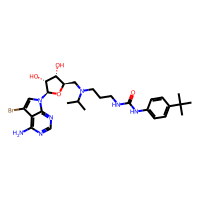
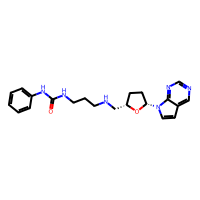
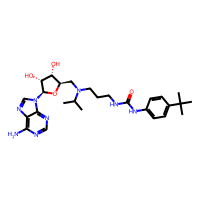
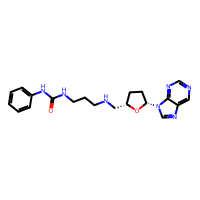

In [57]:
#Addition of the molecule and scaffold columns
PandasTools.AddMoleculeColumnToFrame(output_df_a, smilesCol="smiles",molCol='molecule')
PandasTools.AddMurckoToFrame(output_df_a, molCol='molecule', MurckoCol='scaffold')
PandasTools.AddMoleculeColumnToFrame(output_df_a, smilesCol="scaffold",molCol='sca_mol')
print(output_df_a.shape)
output_df_a[0:2]

In [58]:
output_df_a.drop("molecule", axis=1, inplace=True)
output_df_a.drop("sca_mol", axis=1, inplace=True)
output_df_a = output_df_a[['molecule_chembl_id','smiles', 'scaffold', 'IC50', 'std_units','pIC50',
      'alogp', 'hba', 'hbd', 'full_mwt','num_ro5_violations', 'psa',
      'heavy_atoms', 'document_chembl_id' ]] #'document_chembl_id'

In [60]:
output_df_a.to_excel('/content/drive/MyDrive/Proyectos/Huawei/Dianas/Files/compounds_c_dnmt1.xlsx')

In [59]:
print(f"DataFrame shape: {output_df_a.shape}")
output_df_a.head()

DataFrame shape: (209, 14)


,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id
0,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2ccc3cncnc32)O1)Nc1c...,0.3,nM,9.522879,3.61,9,5,618.58,1,150.79,40,CHEMBL4477246
1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2cnc3cncnc32)O1)Nc1c...,2.9,nM,8.537602,2.25,10,5,540.67,1,163.68,39,CHEMBL4477246
2,CHEMBL83747,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,18.6,nM,7.730487,3.68,10,6,664.40,2,163.84,36,CHEMBL2046381
3,CHEMBL4215326,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC1...,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...,21.0,nM,7.677781,4.79,7,1,476.62,0,63.00,35,CHEMBL4190398
4,CHEMBL1201129,Nc1ncn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)n1,O=c1ncncn1[C@H]1CCCO1,30.0,nM,7.522879,-2.14,8,3,228.21,0,123.49,16,CHEMBL4130634


<a name='2'></a>

# **Graphics**

<a name='2.1'></a>

## ***Percentage of identity***
In the following part we will generate a visual representation of the percentage identity that exists between compounds with reported activity against DNMT1.
The identity is calculated taking into account the Morgan fingerprint and the Tamimoto coefficient as metric.

In [62]:
id=pd.read_excel('/content/drive/MyDrive/Proyectos/Huawei/Dianas/Files/compounds_c_dnmt1.xlsx',index_col=[0], engine='openpyxl')

In [82]:
id.sort_values(by=["molecule_chembl_id"], ascending=True, inplace=True)
# Reset index
id.reset_index(drop=True, inplace=True)
id.head(5)

,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id
0,CHEMBL115145,O=C(O)c1cc(Cc2ccc(O)c(C(=O)O)c2)ccc1O,c1ccc(Cc2ccccc2)cc1,92000.0,nM,4.036212,2.08,4,4,288.25,0,115.06,21,CHEMBL1157722
1,CHEMBL1201129,Nc1ncn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)n1,O=c1ncncn1[C@H]1CCCO1,30.0,nM,7.522879,-2.14,8,3,228.21,0,123.49,16,CHEMBL4130634
2,CHEMBL1231795,COc1cc2c(NC3CCN(C(C)C)CC3)nc(C3CCCCC3)nc2cc1OC...,c1cc2c(NC3CCNCC3)nc(C3CCCCC3)nc2cc1OCCCN1CCCC1,2010.0,nM,5.696804,5.84,7,1,509.74,2,62.75,37,CHEMBL4130634
3,CHEMBL1235825,CN(CC[C@H](N)C(=O)O)C[C@H]1O[C@@H](n2cnc3c(N)n...,c1ncc2ncn([C@H]3CCCO3)c2n1,302000.0,nM,3.519993,-2.24,11,5,381.39,1,185.87,27,CHEMBL2016468
4,CHEMBL1489,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,O=c1ncncn1[C@H]1CCCO1,300.0,nM,6.522879,-3.17,9,4,244.21,0,143.72,17,CHEMBL4130634


In [83]:
def tanimoto_calc(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
    s = round(DataStructs.TanimotoSimilarity(fp1,fp2),3)
    return s

In [84]:
tic =time.time()
hmap=pd.DataFrame()
for i in id.index:
    for j in id.index:
        a=id.loc[i].at['smiles']
        b=id.loc[j].at['smiles']
        alignment= tanimoto_calc(a,b)
        hmap.loc[id.loc[i,'molecule_chembl_id'],id.loc[j,'molecule_chembl_id']]=alignment
toc =time.time()
print("Execution time: "+ str((toc-tic))+" s")

Execution time: 79.25979447364807 s


In [85]:
hmap.to_excel('/content/drive/MyDrive/Proyectos/Huawei/Dianas/Files/compound_aligment_dnmt1.xlsx')
hmap.head()

,CHEMBL115145,CHEMBL1201129,CHEMBL1231795,CHEMBL1235825,CHEMBL1489,CHEMBL1564869,CHEMBL1916517,CHEMBL1916669,CHEMBL1916672,CHEMBL1916680,...,CHEMBL562689,CHEMBL563024,CHEMBL563570,CHEMBL563782,CHEMBL563938,CHEMBL563946,CHEMBL564052,CHEMBL564768,CHEMBL597113,CHEMBL83747
CHEMBL115145,1.000,0.068,0.045,0.073,0.070,0.167,0.083,0.074,0.110,0.056,...,0.040,0.081,0.074,0.040,0.045,0.084,0.041,0.072,0.157,0.191
CHEMBL1201129,0.068,1.000,0.080,0.175,0.516,0.085,0.116,0.123,0.088,0.148,...,0.173,0.140,0.165,0.173,0.181,0.175,0.178,0.184,0.088,0.065
CHEMBL1231795,0.045,0.080,1.000,0.074,0.073,0.060,0.071,0.074,0.062,0.082,...,0.088,0.079,0.082,0.088,0.071,0.074,0.075,0.081,0.070,0.038
CHEMBL1235825,0.073,0.175,0.074,1.000,0.266,0.095,0.110,0.137,0.097,0.103,...,0.455,0.370,0.343,0.455,0.511,0.390,0.469,0.400,0.078,0.060
CHEMBL1489,0.070,0.516,0.073,0.266,1.000,0.099,0.093,0.099,0.078,0.110,...,0.250,0.214,0.255,0.250,0.282,0.266,0.258,0.277,0.090,0.066


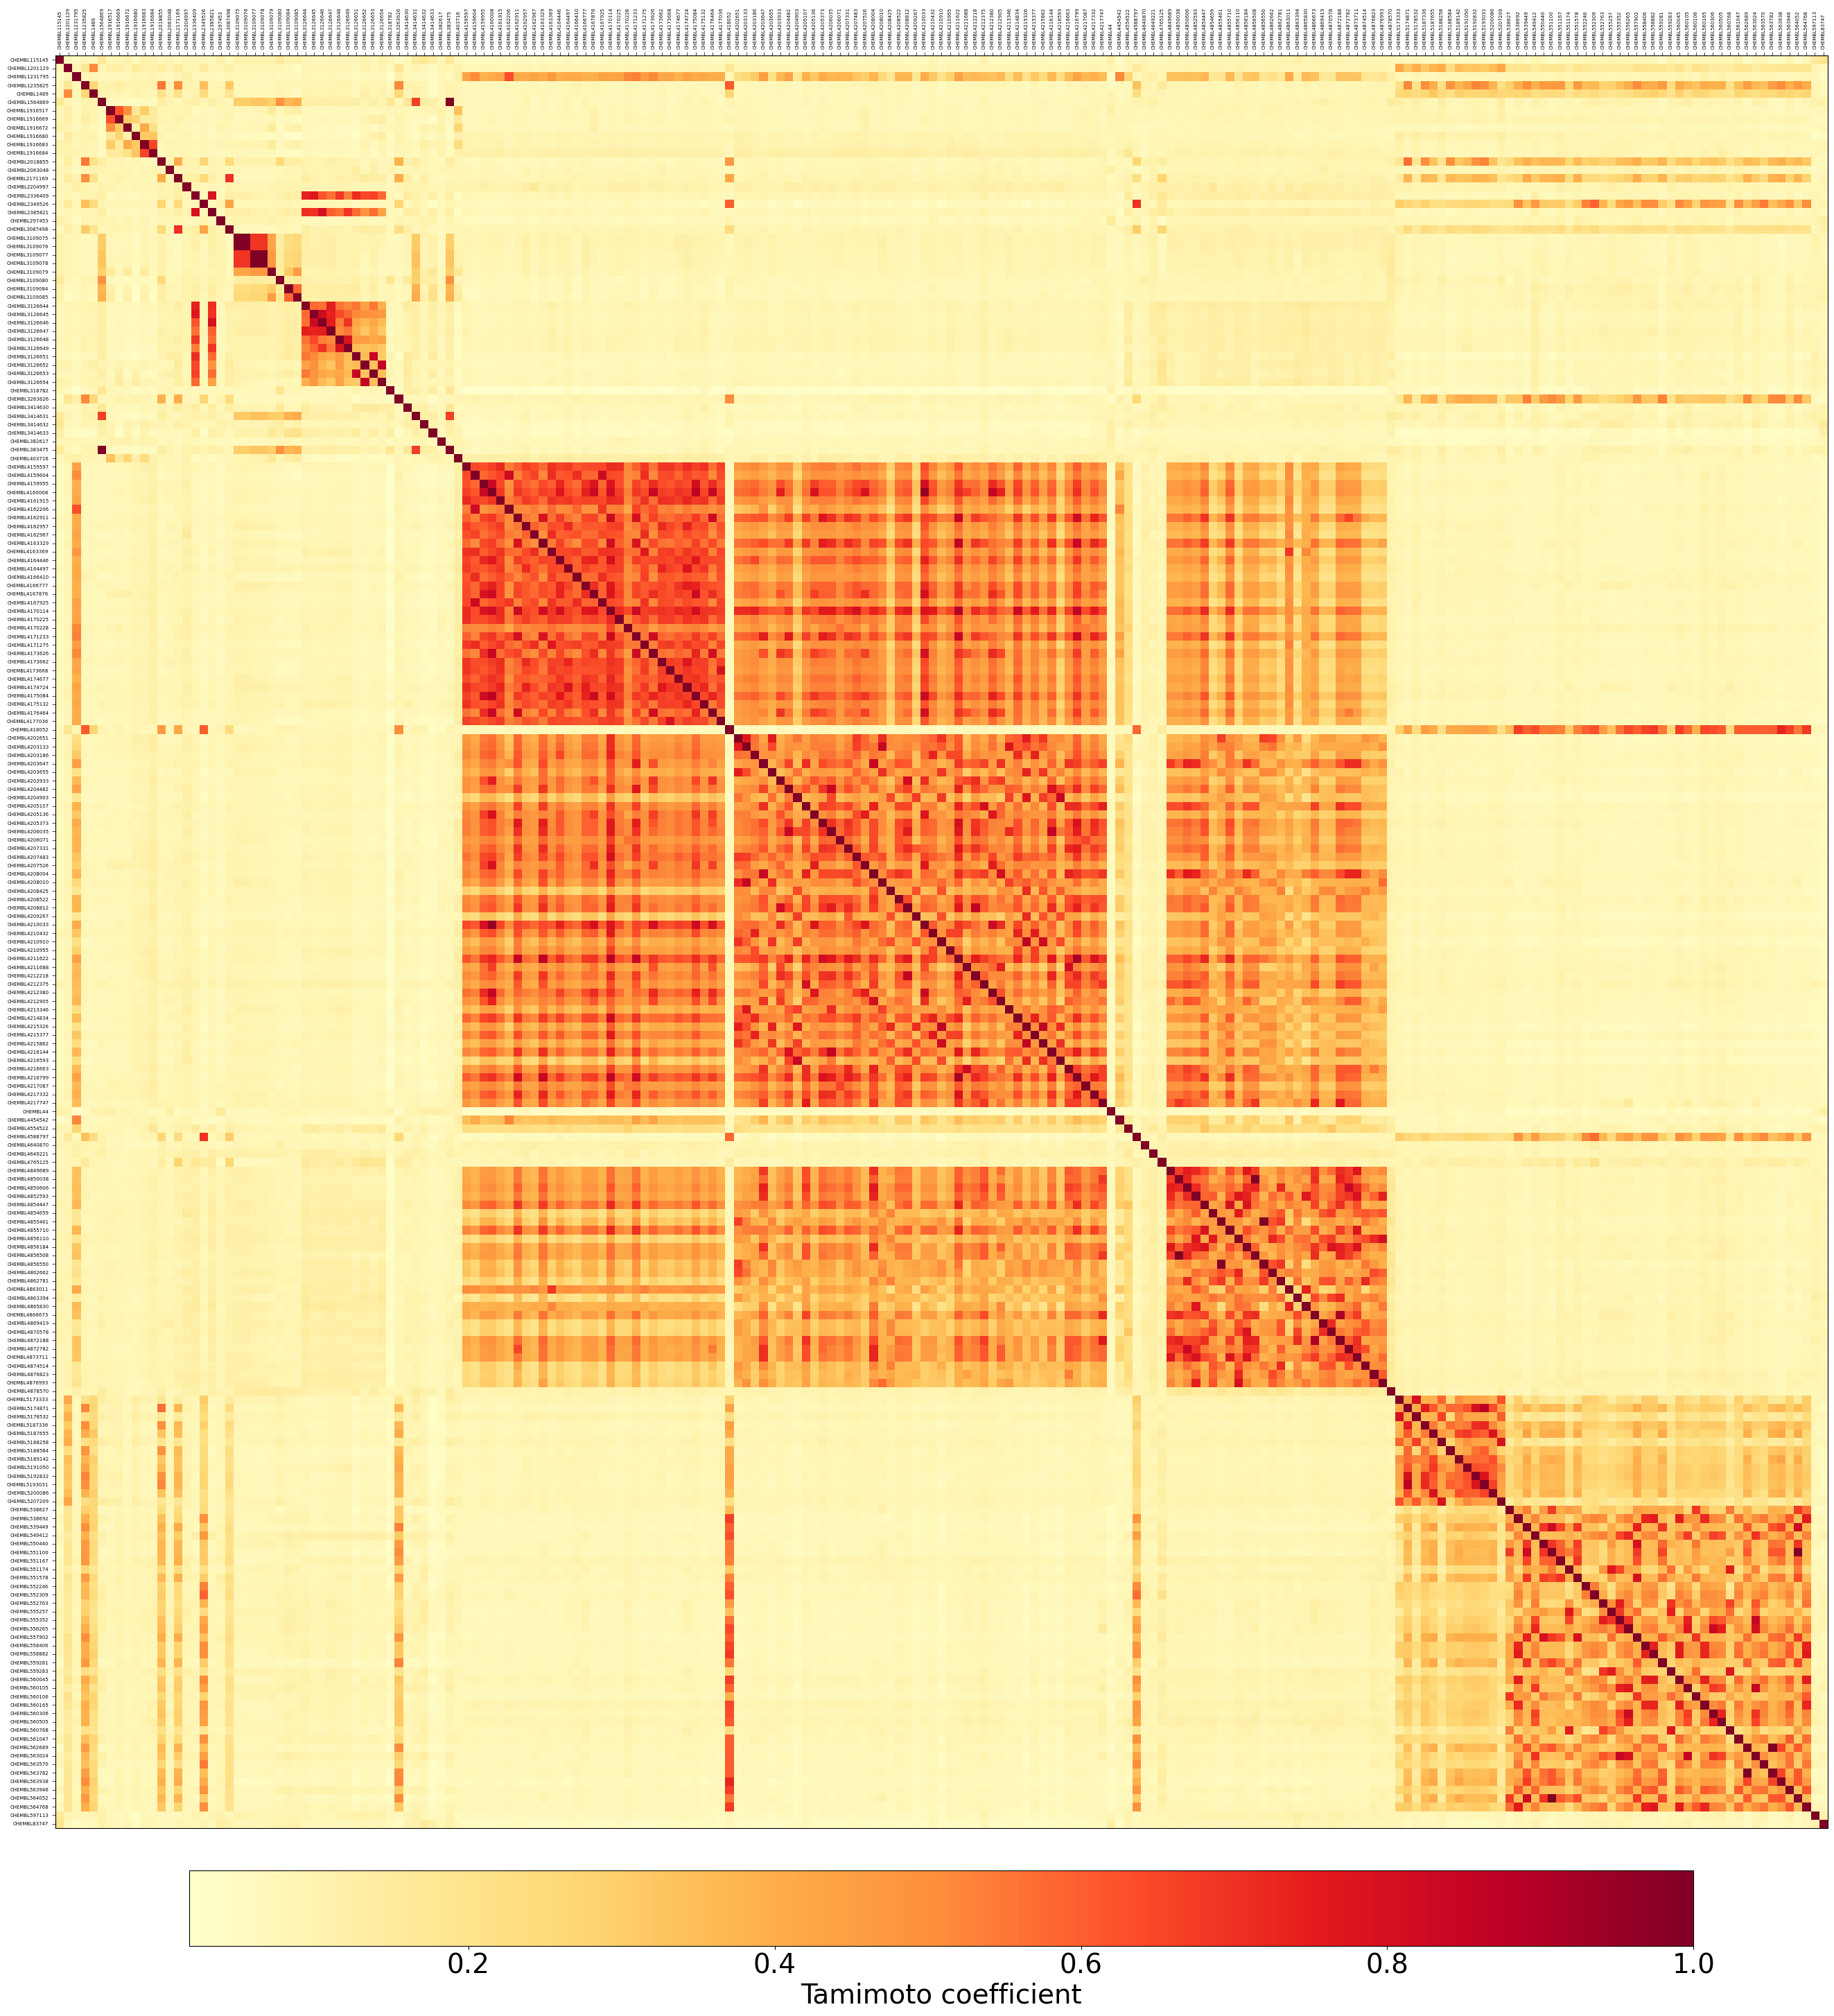

In [87]:
fig, ax = plt.subplots(figsize=(40,40))
plt.imshow (hmap,cmap='YlOrRd', interpolation='nearest')
plt.xticks (range(len(hmap.index)),hmap.index,rotation=90)
plt.yticks (range(len(hmap.index)),hmap.columns)
ax.xaxis.tick_top()
m=plt.colorbar(shrink=0.7,orientation='horizontal',spacing='uniform',pad=0.02)
#(shrink=0.7,orientation='horizontal',spacing='uniform',pad=0.02)
m.set_label ('Tamimoto coefficient',size=28)
m.ax.tick_params(labelsize=28)
plt.tick_params ('both',width=0.5,labelsize=5)
#plt.savefig('/content/drive/MyDrive/Proyectos/G9a/Figuras/aligment_molecules_ChEMBL_hmap.png',dpi=600,format='png',transparent=False)
plt.show()

<a name='3'></a>
#**References**

1.   https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html
2.   https://gist.github.com/leelasd/746f3c447805fc6ea5aad1071bd77aef


<a name='4'></a>
#**Acknowledgments**
**Contributor:** [Diana L. Prado-Romero](https://www.linkedin.com/in/diana-lorena-prado-romero)
**Contact:**
pradodiana93@gmail.com
